# Student Project II
- ### Niko Ganev
- ### 03/22/2019

## Northwind Database

For this project, I will be working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company.

The goal of this project is to showcase my ability to gather information from a real-world database and use knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company. 

<br /><br />
<img src="Northwind_ERD.png" style="width:80%;" alt="Database Schema" />
<br /><br />

In [1]:
#Importing Libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings

## Formulating questions for the analysis

- **Question 1**: a.Is there a Statistically significant difference between discount levels?
             b.Does the amount of the discount matter?
            
- **Question 2**: Is there a statistically significant difference in discount between categories?

- **Question 3**: Do discounts increase quantity of a single product purchased in an order?

- **Question 4**: Are there regions where discounts have a significantly higher effect on quantity purchased compared to the other regions?

## Processing Data and checking for normality in distribution of quantities per order

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
#checkin table names inside Data Base
#-------------------------------------------------------------------------------------------------------------------------------
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""").fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [4]:
#Looking into Orderdetails table
#-------------------------------------------------------------------------------------------------------------------------------
order_details=pd.read_sql("""SELECT * FROM [OrderDetail];""",con=conn)
order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [5]:
df=pd.DataFrame()
for col in ['Quantity','Discount']:
    df[col]=order_details[col]
df.head(10)

,Quantity,Discount
0,12,0.00
1,10,0.00
2,5,0.00
3,9,0.00
4,40,0.00
5,10,0.00
6,35,0.15
7,15,0.15
8,6,0.05
9,15,0.05


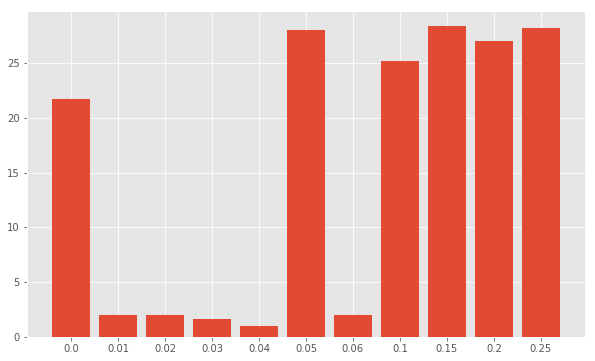

In [6]:
#lets plot the means of quantities purchased against discounts to check
#if visually there seems to be a significatn difference
#------------------------------------------------------------------------------------------
discounts=sorted(list(df.Discount.unique()))
x=[str(i) for i in discounts]
y=[]
for discount in discounts:
    mean=df.Quantity[df['Discount']==discount].mean()
    y.append(round(mean,2))
plt.figure(figsize=(10,6))
plt.bar(x, y)


discounts.remove(0)

Discounts seem to have a higher mean quantity per order.

The sample contains 838 observations, having a mean of 27.10978520286396 and a standard deviation (sigma) =  20.77143923484604 , with 837 degrees of freedom. The difference between sample and population means is: 5.394523243866239


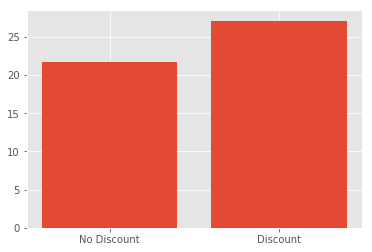

In [7]:
#plotting mean of no discount sv mean of quantities with discount
#------------------------------------------------------------------------------------------
h=[df.Quantity[df['Discount']==0].mean(),df.Quantity[df['Discount']!=0].mean()]
plt.figure(figsize=(6,4))
plt.bar(['No Discount','Discount'],h)



population=df.Quantity[df['Discount']==0]
sample=df.Quantity[df['Discount']!=0]

mu=population.mean()
x_bar=sample.mean()   
sigma=sample.std()
n=len(sample)
dff=n-1

diff = x_bar - mu

print ('The sample contains', n, 'observations, having a mean of', x_bar, "and a standard deviation (sigma) = ", sigma, 
       ", with", dff, 'degrees of freedom. The difference between sample and population means is:', diff)


This second comparison reinforces the idea that it is likely for orders with discounts to exhibit higher quantities ordered.

##### Drawing a distribution from sample values to check for normality

Skewness: 1.584410
Kurtosis: 3.312448


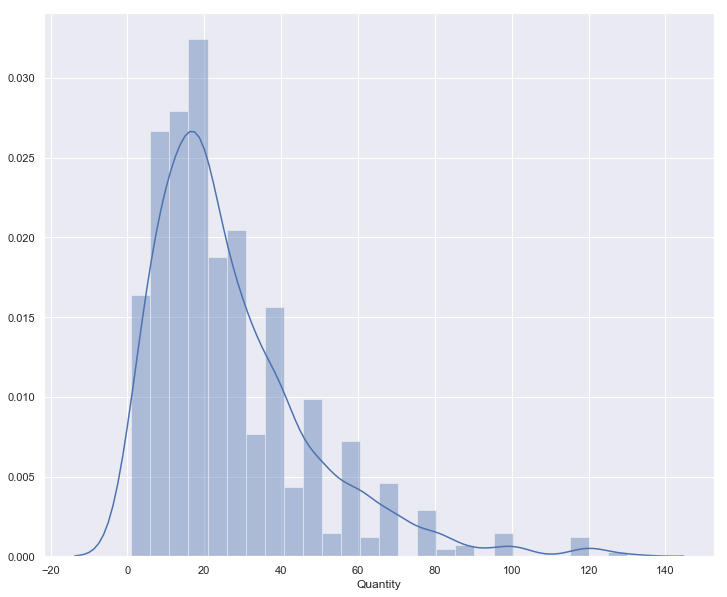

In [8]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(sample)

print("Skewness: %f" % sample.skew())
print("Kurtosis: %f" % sample.kurt())


Since the sample exhibits skewness the Kolmogorov-Smirnov (KS) test for normality will let us check if we can safely run our hypothesis testing

In [9]:
#creating a function to plot KS test
#--------------------------------------------------------------------------
def ks_plot(data):

    plt.figure(figsize=(10, 7))
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False))
    plt.plot(np.sort(stats.norm.rvs(loc=mu, scale=df.Quantity.std(), size=len(data))), np.linspace(0, 1, len(data), endpoint=False))

    plt.legend(['ECDF', 'CDF'])
    plt.title('Comparing CDFs for KS-Test, Sample size=' + str(len(data)))

KstestResult(statistic=0.12097507077796603, pvalue=3.81341624944298e-11)


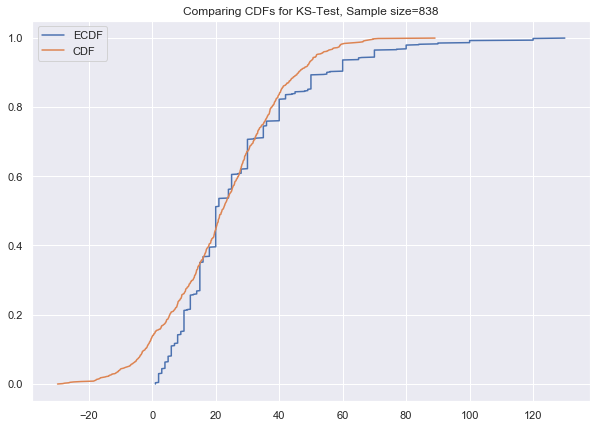

In [10]:
#checking for Normality by comparting the CDF of the distribution 
#to a normal distribution with same mean ans standard deviation 
#--------------------------------------------------------------------------
ks_plot(sample)
print (stats.kstest(sample, 'norm', args=(df.Quantity.mean(), df.Quantity.std())))

- ### Result
KS test confirms normality requirement is met.

## Question 1.a: Is there a Statistically significant difference in quantity order when there is a discount compared to no discount. 

$H_0$: "The discount has NO effect on the number of products customers order"
$H_0$: mu=x_bar

$H_\alpha$: "The discount has an effect on the number of products customers order"
$H_\alpha$ : mu<x_bar

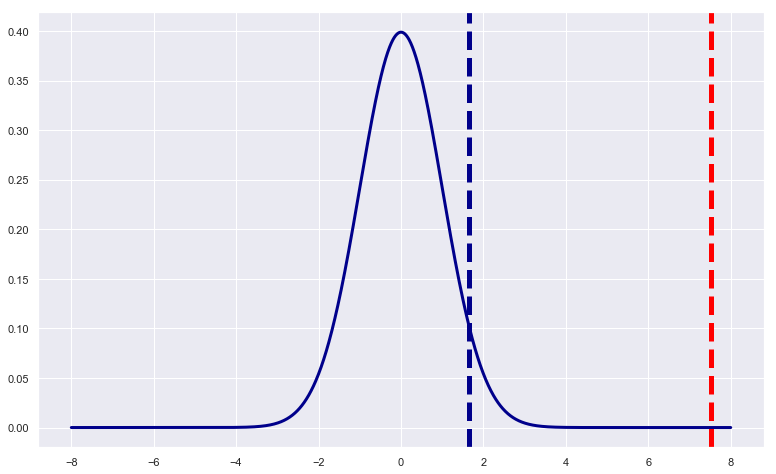

In [11]:
#Calculating and plotting t-value vs critical t-value
#----------------------------------------------- 
t = (x_bar -  mu)/(sigma/np.sqrt(n))
t_crit = np.round(stats.t.ppf(1 -0.05, df=dff),3)

xs = np.linspace(-8, 8, 2000)
ys = stats.t.pdf(xs, dff, 0, 1)
fig = plt.figure(figsize=(13,8))
ax = fig.gca()
ax.plot(xs, ys, linewidth=3, color='darkblue')

# plotting a vertical line for our measured difference in rates t-statistic vs critical t
ax.axvline(t, color='red', linestyle='--', lw=5)
ax.axvline(t_crit, color='darkblue', linestyle='--', lw=5)

plt.show()

In [12]:
t_crit = np.round(stats.t.ppf(1 - 0.05, df=dff),3)
print("The critical t-value for sample is",t_crit)

results = stats.ttest_1samp(a= sample, popmean= mu)         
print ("The t-value for sample is", round(results[0], 2), "and the p-value is", np.round((results[1]), 4))

The critical t-value for sample is 1.647
The t-value for sample is 7.52 and the p-value is 0.0


- ### Result for 1.a:
We reject the null hypothesis and conclude that the mean number of articles sold on orders with discounts is statistically significantly higher than the mean number of articles sold on orders without discounts at a significance level of 1% or even less.

## Question 1.b : Does the amount of the discount matter?

##### Formulating the Hypothesis 
$H_0$: "The percentage of discount has NO effect on the number of products customers order"


$H_\alpha$: "The percentage of discount has an effect on the number of products customers order"

##  

We are going to test each discount level quantity mean against the population mean


In [13]:
for discount in discounts:
    data=df.Quantity[df['Discount']!=discount]
    results = stats.ttest_1samp(a= data, popmean= mu) 
    
    print ("For a discount of",discount*100,"% The t-value for sample is", round(results[0], 2), "and the p-value is", np.round((results[1]), 4),'\n')

For a discount of 1.0 % The t-value for sample is 5.14 and the p-value is 0.0 

For a discount of 2.0 % The t-value for sample is 5.17 and the p-value is 0.0 

For a discount of 3.0 % The t-value for sample is 5.19 and the p-value is 0.0 

For a discount of 4.0 % The t-value for sample is 5.14 and the p-value is 0.0 

For a discount of 5.0 % The t-value for sample is 4.05 and the p-value is 0.0001 

For a discount of 6.0 % The t-value for sample is 5.14 and the p-value is 0.0 

For a discount of 10.0 % The t-value for sample is 4.67 and the p-value is 0.0 

For a discount of 15.0 % The t-value for sample is 4.13 and the p-value is 0.0 

For a discount of 20.0 % The t-value for sample is 4.32 and the p-value is 0.0 

For a discount of 25.0 % The t-value for sample is 4.16 and the p-value is 0.0 



- ### Result for question 1.b:
Since all the values are statistically significant at a significance level of 5% or less, we can say at that level of confidence that the actual amount of the discount does not really matter as long as there is a discount. Note that the values for 1%, 2% and 3% discounts are not reliable because only a few orders with these levels of discounts are available. More data would be needed.



## Question 2: Is there a statistically significant difference in discount between categories?

$H_0$: There is no difference in discount level between categories.

$H_\alpha$: There is a difference in discount level between categories.

In [14]:
category_discount = pd.read_sql_query('''

                        SELECT OrderDetail.UnitPrice, Discount, CategoryId FROM OrderDetail
                        JOIN Product 
                        ON OrderDetail.ProductId = Product.Id''',conn)

category_discount.head(10)



,UnitPrice,Discount,CategoryId
0,14.0,0.00,4
1,9.8,0.00,5
2,34.8,0.00,4
3,18.6,0.00,7
4,42.4,0.00,7
5,7.7,0.00,8
6,42.4,0.15,7
7,16.8,0.15,2
8,16.8,0.05,5
9,15.6,0.05,5


In [15]:
formula = 'Discount ~ C(CategoryId)'
lm = ols(formula, category_discount).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df         F    PR(>F)
C(CategoryId)   0.074918     7.0  1.539545  0.149326
Residual       14.925422  2147.0       NaN       NaN


- ### Result

There is no statistically significant difference in discount level between the eight categories at the 5% significance level, no post hoc test required.

## Question 3 : Do discounts increase quantity of product purchased in an order?

$H_0$: There is no difference in quantity of a single product purchased in an order due to discount on that same product.

$H_\alpha$: Discount on a product increases the quantity purchased per order.


In [16]:
product_discounts = pd.read_sql_query('''

                        SELECT ProductId, ProductName,
                         Quantity, Discount FROM OrderDetail
                        JOIN Product 
                        ON OrderDetail.ProductId = Product.Id''',conn)

product_discounts.head()

,ProductId,ProductName,Quantity,Discount
0,11,Queso Cabrales,12,0.0
1,42,Singaporean Hokkien Fried Mee,10,0.0
2,72,Mozzarella di Giovanni,5,0.0
3,14,Tofu,9,0.0
4,51,Manjimup Dried Apples,40,0.0


In [17]:
#Creating an empty DataFrame witch column names
#----------------------------------------------------------------------------
discount_per_product=pd.DataFrame(columns=['ProductId','Name','TotalOrders','DiscountedOrders','MeanQuantity',
                          'MeanQuantityDiscounted','TValues','PValues','StatisticallySignificant'])

#Creating empty lists to contain column information before adding to DataFrame
#---------------------------------------------------------------------
ProductId=[]
Name=[]
TotalOrders=[]
DiscountedOrders=[]
TValues=[]
PValues=[]
StatisticallySignificant=[]
MeanQuantity=[]
MeanQuantityDiscounted=[]

#Gathering Data
#---------------------------------------------------------------------

for i in range(1,len(product_discounts.ProductId.unique())+1):

    #for each product creating a dataframe of all orders and 
    #then splitting between dsicounted and not discounted
    #----------------------------------------------------------------
    b=product_discounts[product_discounts['ProductId']==i]
    nodisc=b[b['Discount']==0]
    disc= b[b['Discount']!=0]
    #Gathering ProductId, Name, TValue, Pvalue for alpha=5% 
    #and number of orders for each product
    #-----------------------------------------------------------------
    name=product_discounts.ProductName[product_discounts['ProductId']==i].unique()[0]
    results = stats.ttest_1samp(a= disc.Quantity, popmean= b.Quantity.mean())
    tvalue=round(results[0], 2)
    pvalue=np.round((results[1]), 4)
    totalorders=len(b)
    meanquantity=round(b.Quantity.mean(),2)
    meanquantitydiscounted=round(disc.Quantity.mean(),2)
    discountorders=len(disc)
    statisticallysignificant= tvalue>np.round(stats.t.ppf(1 - 0.05, df=len(disc)-1),3)
    #Adding Data To Vectors that will be combined into a DataFrame
    #------------------------------------------------------------------
    ProductId.append(i)
    Name.append(name)
    TotalOrders.append(totalorders)
    DiscountedOrders.append(discountorders)
    MeanQuantity.append(meanquantity)
    MeanQuantityDiscounted.append(meanquantitydiscounted)
    TValues.append(tvalue)
    PValues.append(pvalue)
    StatisticallySignificant.append(statisticallysignificant)
    

#Adding to Dataframe
#---------------------------------------------------------------------
discount_per_product.ProductId=ProductId
discount_per_product.Name=Name
discount_per_product.TotalOrders=TotalOrders
discount_per_product.DiscountedOrders=DiscountedOrders
discount_per_product.MeanQuantity=MeanQuantity
discount_per_product.MeanQuantityDiscounted=MeanQuantityDiscounted
discount_per_product.TValues=TValues
discount_per_product.PValues=PValues
discount_per_product.StatisticallySignificant=StatisticallySignificant

#Looking at resulting DataFrame
#----------------------------------------------------------------------
discount_per_product.head()




,ProductId,Name,TotalOrders,DiscountedOrders,MeanQuantity,MeanQuantityDiscounted,TValues,PValues,StatisticallySignificant
0,1,Chai,38,16,21.79,27.31,1.040000,0.3166,False
1,2,Chang,44,25,24.02,25.96,0.480000,0.6327,False
2,3,Aniseed Syrup,12,2,27.33,20.00,-inf,0.0000,False
3,4,Chef Anton's Cajun Seasoning,20,10,22.65,28.10,1.070000,0.3142,False
4,5,Chef Anton's Gumbo Mix,10,4,29.80,30.50,0.060000,0.9577,False


In [18]:
#For how many products did quantity 
#in the same order increase with discount?
#---------------------------------------------------------------------
len(discount_per_product[discount_per_product['StatisticallySignificant']==True])



0

#### Results

Fail to reject null hypothesis for all 77 products. There is no statistical difference at the 5% level of significance in the number of single product customers will order on the same order whether there is a discount on them or not. In other words, statistically speaking, people won't buy more of the same because it's discounted, they will use the money to buy other products.


## Question 4 : Are there regions where discounts have a significantly higher effect on quantity purchased compared to the other regions?

$H_0$: Discounts have the same effect in all regions

$H_\alpha$: Discounts increase quantity more significantly in certain regions.

We are going to compare the mean quantity on disocunted orders in each region to the mean quantity on discounted orders in all regions combined.

In [19]:
orders_per_region = pd.read_sql_query('''

                        SELECT  Region, OrderId, ProductId, Discount , CustomerId, Quantity FROM [OrderDetail] od
                        JOIN [Order] o
                        ON od.OrderId = o.Id
                        JOIN [Customer] c
                        ON o.CustomerId = c.Id
                        
                        ''',conn)

#Isolating orders with discounts
#-------------------------------------------------------------------------------------------------------------------------------
discorders_per_region=orders_per_region[orders_per_region['Discount']!=0]
discorders_per_region.head()

,Region,OrderId,ProductId,Discount,CustomerId,Quantity
6,South America,10250,51,0.15,HANAR,35
7,South America,10250,65,0.15,HANAR,15
8,Western Europe,10251,22,0.05,VICTE,6
9,Western Europe,10251,57,0.05,VICTE,15
11,Western Europe,10252,20,0.05,SUPRD,40


In [20]:
mean_discountedorders = discorders_per_region.Quantity.mean()
significant=[]
not_significant=[]

for region in orders_per_region.Region.unique():
    
    b=discorders_per_region[discorders_per_region['Region']==region]
    mean=round(b.Quantity.mean(),2)
    results = stats.ttest_1samp(a= b.Quantity, popmean= mean_discountedorders)
    t_crit = np.round(stats.t.ppf(1 - 0.05, df=len(b)),3)
    if results[0]>t_crit and results[1]<0.05:
        significant.append(b.Region.unique())
    else:
        not_significant.append(b.Region.unique())

print( 'In the region(s) of',significant[0],'discounts have a statistically significant impact on quantity at the 5% level of confidence.')
    #print ("For the region of",region,", The t-value for sample is", round(results[0], 2), "and the p-value is", np.round((results[1]), 4),'\n')

In the region(s) of ['North America'] discounts have a statistically significant impact on quantity at the 5% level of confidence.


#### Results

We Reject the Null Hypothesis at the 5% level of confidence for the region of North America where quantity purchased when there is a discount is statistically significantly higher compared to quantity purchased in other regions when there is a discount.


## Question 5: Can we find geographical areas as small as zipcodes that order significantly higher total quantity of products?

We will be comparing the average total quantity of products ordered per oder and per zipcode to average quantity per order.

$H_0$: No zipcode orders significantly higher quantity of products per order.

$H_\alpha$: Some zipcodes tend to place orders with higher quantities.



In [21]:
orders_per_postalcode = pd.read_sql_query('''

                        SELECT  OrderId, Quantity, ShipPostalCode FROM [OrderDetail] od
                        JOIN [Order] o
                        ON od.OrderId = o.Id
                        
                        ''',conn)

orders_per_postalcode.head()

,OrderId,Quantity,ShipPostalCode
0,10248,12,51100
1,10248,10,51100
2,10248,5,51100
3,10249,9,44087
4,10249,40,44087


In [22]:
orders_per_postalcode.isna().sum()

OrderId            0
Quantity           0
ShipPostalCode    55
dtype: int64

In [23]:
orders_per_postalcode.dropna(inplace=True)

In [24]:
orders = orders_per_postalcode['OrderId'].unique()
groups = {}
for i in orders:
    groups[i] = orders_per_postalcode[orders_per_postalcode['OrderId']==i]

In [25]:
zipcodes = pd.DataFrame(columns=orders_per_postalcode.columns)
for i in groups.keys():
    code=list(groups[i]['ShipPostalCode'])
    zipcodes = zipcodes.append({'OrderId':i,'Quantity':groups[i]['Quantity'].sum(),'ShipPostalCode':code[0]}, ignore_index=True)
        
zipcodes.head()

,OrderId,Quantity,ShipPostalCode
0,10248,27,51100
1,10249,49,44087
2,10250,60,05454-876
3,10251,41,69004
4,10252,105,B-6000


In [26]:
mu=zipcodes.Quantity.mean()
mu


61.199753390875465

In [27]:
for code in list(orders_per_postalcode.ShipPostalCode.unique()):
    data=orders_per_postalcode[orders_per_postalcode['ShipPostalCode']==code]['Quantity']
    if len(data)>3:
        results = stats.ttest_1samp(a= data, popmean= mu)
        if round(results[1],2)<0.05:
            print(code,'T-Stat is',round(results[0],2),'P-Value is',round(results[1],2))



51100 T-Stat is -28.46 P-Value is 0.0
44087 T-Stat is -14.73 P-Value is 0.0
05454-876 T-Stat is -12.88 P-Value is 0.0
69004 T-Stat is -20.64 P-Value is 0.0
B-6000 T-Stat is -14.41 P-Value is 0.0
3012 T-Stat is -17.37 P-Value is 0.0
1204 T-Stat is -10.99 P-Value is 0.0
08737-363 T-Stat is -28.7 P-Value is 0.0
5022 T-Stat is -15.15 P-Value is 0.0
8010 T-Stat is -5.54 P-Value is 0.0
50739 T-Stat is -19.06 P-Value is 0.0
02389-673 T-Stat is -23.43 P-Value is 0.0
87110 T-Stat is -18.8 P-Value is 0.0
S-844 67 T-Stat is -14.02 P-Value is 0.0
67000 T-Stat is -13.95 P-Value is 0.0
90110 T-Stat is -22.57 P-Value is 0.0
80805 T-Stat is -13.19 P-Value is 0.0
1081 T-Stat is -35.13 P-Value is 0.0
98124 T-Stat is -13.48 P-Value is 0.0
82520 T-Stat is -24.11 P-Value is 0.0
01307 T-Stat is -5.51 P-Value is 0.0
24100 T-Stat is -14.83 P-Value is 0.0
05033 T-Stat is -39.8 P-Value is 0.0
04179 T-Stat is -21.84 P-Value is 0.0
S-958 22 T-Stat is -25.95 P-Value is 0.0
60528 T-Stat is -24.99 P-Value is 0.0
280

#### Results

Since all the values are statistically significant at a significance level of 5% or less, we can say at that level of confidence that there is no zipcode(s) that stands out when it comes to quantity ordered. The zipcode level might be too small, too detailed for the analysis, we can try analyzing per city or country.


# Conclusion

- Discounts do improve the overall quantity ordered regardless of the level of discount
- Discounts do no increase the quantity of the discounted products in the order but rather allow people to purchase different types of products
- No category stands out when it comes to effect of the discount.
- Discounts seem to be most efficient in North America
- No specific zipcodes stand out as of effect of discounts

## Further Steps

- Do the discount analysis on revenue, establish if customers end up spending more
- Analyze employees performance 
- Analyze Shipping companies performance and effect on bottom line
